In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt('train.csv', delimiter=',',skip_header=1)
data.shape

(42000, 785)

In [3]:
# normalize X
X = (data[:,1:]/255).reshape(-1,28,28,1)
# one hot encode y
y = np.zeros(shape=(len(X),10),dtype=int)
y[np.arange(len(data)),data[:,0].astype(int)] = 1

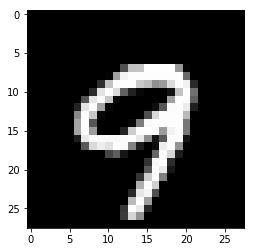

(9, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))

In [4]:
# sample image
i = np.random.randint(len(X))
plt.imshow(X[i].reshape(28,28),cmap='gray')
plt.show()
np.argmax(y[i]),y[i]

In [5]:
from keras.models import Model, Sequential
from keras.layers import Convolution2D, LeakyReLU, BatchNormalization, Flatten
from keras.layers import Dense, Input, Reshape, ReLU, Conv2DTranspose, Activation

Using TensorFlow backend.


In [6]:
input_layer = Input(shape = X[0].shape)
x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same')(input_layer)
x = LeakyReLU(0.2)(x)
x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
x = LeakyReLU(0.2)(x)
x = Convolution2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
x = LeakyReLU(0.2)(x)
x = Flatten()(x)
output = (Dense(1,activation='sigmoid'))(x)

discriminator = Model(inputs=input_layer,outputs=output)
discriminator.compile(optimizer='adam',loss='binary_crossentropy')

discriminator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv

In [7]:
input_layer = Input(shape=(1,1,100))
x = Dense(2048)(input_layer)
x = Reshape(target_shape=(4, 4, 128))(x)
x = BatchNormalization(momentum=0.5)(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', output_padding=(0,0))(x)
x = BatchNormalization(momentum=0.5)(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
output = Activation('tanh')(x)

generator = Model(inputs = input_layer,outputs = output)
generator.compile(optimizer='adam',loss='binary_crossentropy')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 1, 100)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1, 2048)        206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 64)          204864    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 64)          256       
__________

In [8]:
discriminator.predict(X[:10])

array([[0.5047945 ],
       [0.49903235],
       [0.49576178],
       [0.49791536],
       [0.50120986],
       [0.5021295 ],
       [0.496387  ],
       [0.49566987],
       [0.49762914],
       [0.5049986 ]], dtype=float32)

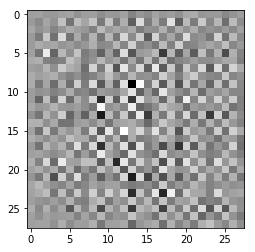

In [9]:
z = np.random.normal(size=(1,1,1,100))

im = generator.predict(z)

plt.imshow(im[0].reshape(28,28),cmap='gray')
plt.show()

In [10]:
gan = Sequential()
discriminator.trainable = False
gan.add(generator)
gan.add(discriminator)

gan.compile(optimizer='adam',loss='binary_crossentropy')

gan.predict(z)

array([[0.5001141]], dtype=float32)

In [ ]:
X_copy = X.copy()
mask = np.random.choice(range(len(X)),size=2000)
X = X[mask]

In [34]:
epochs = 200
batch_size = 100
generator_ratio = 2

for epoch in range(epochs):
    print('Epoch: ',epoch)
    for batch in range(len(X)//batch_size):
        # normalize data to -1, 1 (works better that way, also in line with tanh output of generator)
        x_b = X[batch*batch_size:(batch+1)*batch_size]*2-1
        y_b = y[batch*batch_size:(batch+1)*batch_size]
        # randomly generate latent values
        z = np.random.normal(size=((len(x_b),)+(1,1,100)))
        images = generator.predict(z)
        # generate labels for discriminator
        real = np.ones(len(x_b)) - np.random.random(size=len(x_b))*0.2
        fake = np.zeros(len(x_b)) + np.random.random(size=len(x_b))*0.2
        
        # train discriminator once
        discriminator.trainable = True
        discriminator.train_on_batch(x_b,real)
        discriminator.train_on_batch(images,fake)
        
        # train generator n times
        for i in range(generator_ratio):
            discriminator.trainable = False
            # generate new images
            z = np.random.normal(size=((len(x_b),)+(1,1,100)))
            # discriminator should be fooled into accepting those images
            fool = np.ones(len(x_b)) - np.random.random(size=len(x_b))*0.2
            gan.train_on_batch(z,fool)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  9

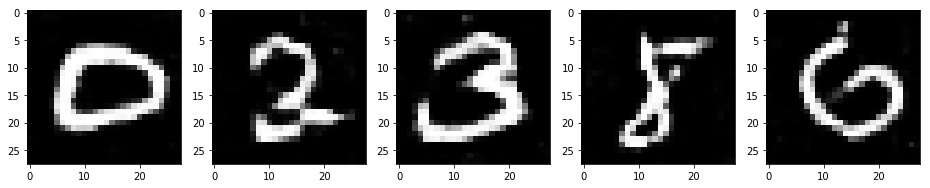

In [43]:
z = np.random.normal(size=(5,1,1,100))

im = generator.predict(z)

fig, ax = plt.subplots(ncols=5,figsize=(16,6))
for i in range(5):
    ax[i].imshow(im[i].reshape(28,28),cmap='gray')
plt.show()